[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main.ipynb)

# Capítulo 6 - SARSA de _n_ passos / Tratando Estados Contínuos


## Configurações Iniciais

In [2]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

#clear_output()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Cloning into 'rl_facil'...
remote: Enumerating objects: 1863, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1863 (delta 81), reused 98 (delta 46), pack-reused 1699 (from 2)
Receiving objects: 100% (1863/1863), 33.47 MiB | 36.23 MiB/s, done.
Resolving deltas: 100% (1209/1209), done.


In [3]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

import numpy as np

from cap06.nstep_sarsa import run_nstep_sarsa

from envs import RacetrackEnv
from envs.wrappers import ObservationDiscretizerWrapper

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable


## 1 - SARSA de n Passos

É uma extensão do SARSA que usa uma sequência de de *n* passos (ou seja, com *n* ações realizadas no ambiente) como entrada para cada atualização da estimativa do $Q(s,a)$.

Com **$n=1$**, ele estima $Q(s,a)$ igual ao *SARSA*:
- usa esta experiência: $s, a, r_1, s_1, a_1$
- calcula a nova estimativa de $Q(s,a)$ assim (para estados não-terminais):
$$Q_{target} = r_1 + \gamma . Q(s_1,a_1)$$
- note que apenas 1 ação foi realizada ($a$) e apenas 1 recompensa foi recebida ($r_1$)
- observe que a última ação ($a_1$) foi escolhida, mas não foi realizada no ambiente

Com **$n=2$**, para estimar $Q(s,a)$, ele:
- usa esta experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2$
- calcula a nova estimativa de $Q(s,a)$ assim:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . Q(s_2,a_2)$$
- esta é uma estimativa mais precisa, que usa os dados de *duas* recompensas reais

Para **$n$ qualquer**:
- experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2, s_3, \cdots, r_n, s_n, a_n$
- nova estimativa:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . r_2 + \cdots + \gamma^n . Q(s_n,a_n)$$

O $n$ será um parâmetro do algoritmo.

O código é mais complexo do que dos algoritmos de 1 passo. Veja o arquivo `cap06/nstep_sarsa.py` para conhecer os detalhes.

Abaixo, vamos importar e usar aquela implementação para fazer um experimento:

In [4]:
# para ambientes gymnasium
#ENV_NAME, r_max = "Taxi-v3", 10
#ENV_NAME, r_max = "CliffWalking-v0", 0
#ENV_NAME, r_max = "FrozenLake-v1", 0
ENV_NAME, r_max = "RaceTrack-v0", 0

env = gym.make(ENV_NAME)

# para ambientes instanciados diretamente
# atenção: vale a pena aplicar um TimeLimit
#env = RacetrackEnv()
#r_max = 0

EPISODES = 5_000
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 5

# Roda o algoritmo "n-step SARSA"
rewards1, qtable1 = run_nstep_sarsa(env, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Episode 100 Average Reward (last 100): -117.830
Episode 200 Average Reward (last 100): -105.020
Episode 300 Average Reward (last 100): -103.460
Episode 400 Average Reward (last 100): -100.320
Episode 500 Average Reward (last 100): -87.210
Episode 600 Average Reward (last 100): -90.390
Episode 700 Average Reward (last 100): -70.300
Episode 800 Average Reward (last 100): -65.420
Episode 900 Average Reward (last 100): -68.610
Episode 1000 Average Reward (last 100): -64.060
Episode 1100 Average Reward (last 100): -71.180
Episode 1200 Average Reward (last 100): -67.240
Episode 1300 Average Reward (last 100): -57.150
Episode 1400 Average Reward (last 100): -51.400
Episode 1500 Average Reward (last 100): -54.430
Episode 1600 Average Reward (last 100): -54.020
Episode 1700 Average Reward (last 100): -46.080
Episode 1800 Average Reward (last 100): -47.580
Episode 1900 Average Reward (last 100): -42.570
Episode 2000 Average Reward (last 100): -39.690
Episode 2100 Average Reward (last 100): -46.0

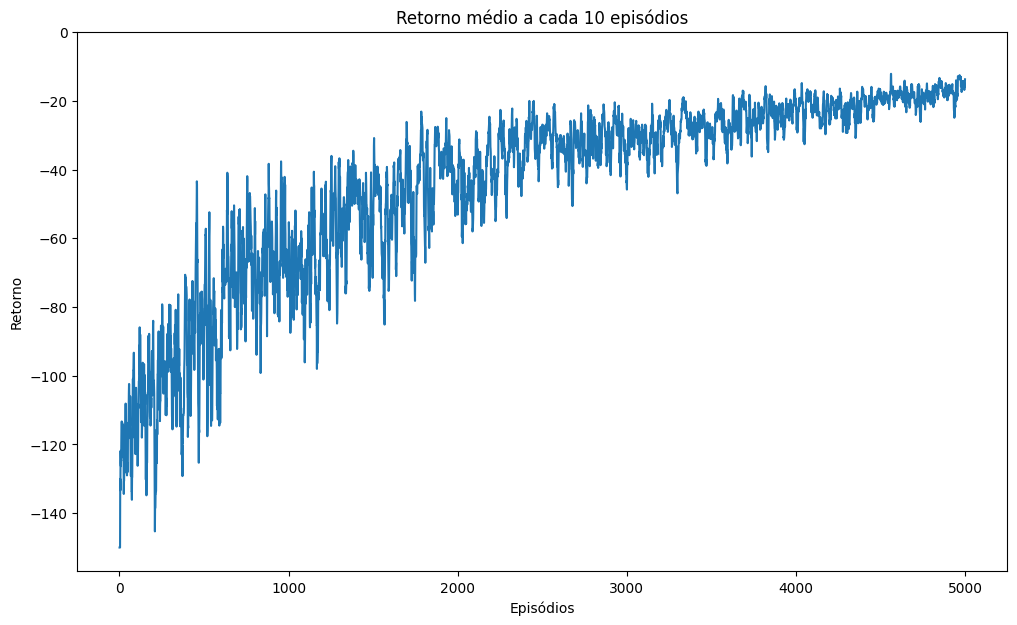

In [5]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max, None)

In [6]:
evaluate_qtable_policy(env, qtable1, 10, epsilon=0.1, verbose=True);

Episódio 1: -33.0
Episódio 2: -10.0
Episódio 3: -12.0
Episódio 4: -35.0
Episódio 5: -25.0
Episódio 6: -30.0
Episódio 7: -47.0
Episódio 8: -8.0
Episódio 9: -15.0
Episódio 10: -35.0
Retorno médio (por episódio): -25.00, episódios: 10, total de passos: 260


In [7]:
# atenção: precisa passar a ID do ambiente no gymnasium ou instanciar diretamente um novo ambiente com o render_mode "rgb_array"
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')
#record_video_qtable(RacetrackEnv(render_mode="rgb_array"), qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')

In [8]:
display_videos_from_path('./videos', prefix='nstep-discrete')

A seguir, vamos rodar alguns experimentos variando a quantidade de passos:

In [9]:
RUNS = 3
results1 = []
for nstep in [1, 2, 3]:
    results1.append( repeated_exec(RUNS, f"{nstep}-step SARSA (LR={LR})", run_nstep_sarsa, env, EPISODES, nstep, LR) )
    clear_output()

In [ ]:
plot_multiple_results(results1, window=30, x_log_scale=True)

## 2 - Lidando com Estados Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes de estados contínuos.

Para isso, vamos usar um *wrapper* que discretiza os estados desses ambientes.

Primeiramente, vamos analisar, abaixo, o espaço de estados de um ambiente contínuo:

In [ ]:
ENV_NAME = "CartPole-v1"
r_max_plot = 200

env2a = gym.make(ENV_NAME)

# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env2a.observation_space)
print("  - formato: ", env2a.observation_space.shape)
print("  - exemplo: ", env2a.reset())

Abaixo, nós encapsulamos o ambiente contínuo em um wrapper para discretizá-lo.

Os parâmetros indicam quantos valores discretos foram usados para representar cada uma das dimensões do estado.

Como resultado, o espaço de estados torna-se do tipo `Discrete`, o que indica que cada "estado" é representado como um único número inteiro.

In [ ]:
# Encapsula o ambiente em nosso wrapper
# atenção para o parâmetro BINS: deve ter um valor para cada componente do estado
BINS = [5, 30, 30, 30]
env2b = ObservationDiscretizerWrapper(env2a, BINS)

env2b.observation_space

Agora, podemos rodar treinamentos com quaisquer dos algoritmos que temos visto. Vamos rodar o *SARSA de n passos*:

In [ ]:
EPISODES = 5_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 4

rewards2, qtable2 = run_nstep_sarsa(env2b, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

In [ ]:
# Gera um gráfico de episódios x retornos (não descontados)
plot_result(rewards2, r_max_plot)

In [ ]:
# Faz alguns testes, usando a tabela de forma greedy
evaluate_qtable_policy(env2b, qtable2, 10, 0.0, verbose=True)

In [ ]:
# Salva vídeo
# Atenção: é recomendado criar nova instância do ambiente e do wrapper!
env_test = gym.make(ENV_NAME, render_mode="rgb_array")
env_test = ObservationDiscretizerWrapper(env_test, BINS)
record_video_qtable(env_test, qtable2, episodes=3, folder='videos/', prefix='nstep-cartpole')

In [ ]:
# Exibe o video
display_videos_from_path('./videos', prefix='nstep-cartpole')

## 3 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [10]:
import optuna

### 3.1 - Ambiente Discreto

Este é o caso mais simples, porque não precisamos aplicar nenhum wrapper.

Primeiro, você precisa fazer uma função que receber um parâmetro do tipo `Trial` (definido no optuna) e retorna uma medida de desempenho.

Dentro da função, você usa o objeto *trial* para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [ ]:
experiments = {
    "nsteps":[2**x for x in range(0, 7)],
    "epsilon":[0.4, 0.2, 0.1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]

}

In [14]:
def train_nstep_sarsa_racetrack(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # outra opção trial.suggest_categorical('param', ['value1', 'value2'])

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente Racetrack, mas insere-o em um wrapper para limitar o tamanho do episódio
    env = gym.make("RaceTrack-v0")

    # roda o algoritmo e recebe os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env, 3000, nsteps, lr=lr, epsilon=eps, gamma=gamma, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


Depois, você cria um "study" do Optuna e manda otimizar sua função, indicando quantas tentativas (trials) ele vai fazer -- ou seja, quantas vezes a sua função vai ser executada.

In [15]:
study1 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_racetrack',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa, rodando "n_trials" vezes
# o parâmetro "n_jobs" indica a quantidade de CPUs a serem usadas (-1 para usar todas)
study1.optimize(train_nstep_sarsa_racetrack, n_trials=20, n_jobs=2)

[I 2025-02-06 17:25:21,055] Using an existing study with name 'nstep_sarsa_racetrack' instead of creating a new one.



TRIAL #21: {'epsilon': 0.1949824725322809, 'gamma': 0.9915669025170257, 'lr': 0.06827991453423375, 'nsteps': 3}

TRIAL #20: {'epsilon': 0.03229215228851032, 'gamma': 0.9935085215432701, 'lr': 0.5093528921097642, 'nsteps': 4}


[I 2025-02-06 17:25:21,691] Trial 21 finished with value: -56.24 and parameters: {'epsilon': 0.1949824725322809, 'gamma': 0.9915669025170257, 'lr': 0.06827991453423375, 'nsteps': 3}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:21,845] Trial 20 finished with value: -63.79 and parameters: {'epsilon': 0.03229215228851032, 'gamma': 0.9935085215432701, 'lr': 0.5093528921097642, 'nsteps': 4}. Best is trial 17 with value: -10.69.



TRIAL #22: {'epsilon': 0.032177553145547086, 'gamma': 0.9765153462012114, 'lr': 0.34797441948060925, 'nsteps': 4}

TRIAL #23: {'epsilon': 0.09250522951517358, 'gamma': 0.9796073340363434, 'lr': 0.2164318347326943, 'nsteps': 7}


[I 2025-02-06 17:25:22,344] Trial 22 finished with value: -63.47 and parameters: {'epsilon': 0.032177553145547086, 'gamma': 0.9765153462012114, 'lr': 0.34797441948060925, 'nsteps': 4}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:22,476] Trial 23 finished with value: -60.36 and parameters: {'epsilon': 0.09250522951517358, 'gamma': 0.9796073340363434, 'lr': 0.2164318347326943, 'nsteps': 7}. Best is trial 17 with value: -10.69.



TRIAL #24: {'epsilon': 0.05902092694621498, 'gamma': 0.9663455163776207, 'lr': 0.6024040434003846, 'nsteps': 8}

TRIAL #25: {'epsilon': 0.0642630899108045, 'gamma': 0.9664110720429291, 'lr': 0.6207563746398043, 'nsteps': 8}


[I 2025-02-06 17:25:23,027] Trial 24 finished with value: -64.77 and parameters: {'epsilon': 0.05902092694621498, 'gamma': 0.9663455163776207, 'lr': 0.6024040434003846, 'nsteps': 8}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:23,087] Trial 25 finished with value: -66.15 and parameters: {'epsilon': 0.0642630899108045, 'gamma': 0.9664110720429291, 'lr': 0.6207563746398043, 'nsteps': 8}. Best is trial 17 with value: -10.69.



TRIAL #26: {'epsilon': 0.011733869825905404, 'gamma': 0.9846256947360892, 'lr': 0.18831703131194827, 'nsteps': 2}


[I 2025-02-06 17:25:23,597] Trial 26 finished with value: -56.64 and parameters: {'epsilon': 0.011733869825905404, 'gamma': 0.9846256947360892, 'lr': 0.18831703131194827, 'nsteps': 2}. Best is trial 17 with value: -10.69.



TRIAL #27: {'epsilon': 0.08769959307705508, 'gamma': 0.9854048930204669, 'lr': 0.07761897996252923, 'nsteps': 2}


[I 2025-02-06 17:25:23,737] Trial 27 finished with value: -62.49 and parameters: {'epsilon': 0.08769959307705508, 'gamma': 0.9854048930204669, 'lr': 0.07761897996252923, 'nsteps': 2}. Best is trial 17 with value: -10.69.



TRIAL #28: {'epsilon': 0.08332532991267591, 'gamma': 0.9490672823980103, 'lr': 0.058617081486593545, 'nsteps': 5}


[I 2025-02-06 17:25:24,134] Trial 28 finished with value: -62.92 and parameters: {'epsilon': 0.08332532991267591, 'gamma': 0.9490672823980103, 'lr': 0.058617081486593545, 'nsteps': 5}. Best is trial 17 with value: -10.69.



TRIAL #29: {'epsilon': 0.04206988386286924, 'gamma': 0.9990725450090011, 'lr': 0.006166531401679992, 'nsteps': 6}

TRIAL #30: {'epsilon': 0.03678997630690547, 'gamma': 0.9720610864989647, 'lr': 0.2541552482699446, 'nsteps': 11}


[I 2025-02-06 17:25:24,745] Trial 29 finished with value: -66.74 and parameters: {'epsilon': 0.04206988386286924, 'gamma': 0.9990725450090011, 'lr': 0.006166531401679992, 'nsteps': 6}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:25,050] Trial 30 finished with value: -62.67 and parameters: {'epsilon': 0.03678997630690547, 'gamma': 0.9720610864989647, 'lr': 0.2541552482699446, 'nsteps': 11}. Best is trial 17 with value: -10.69.



TRIAL #31: {'epsilon': 0.049071353302013135, 'gamma': 0.9800811181805155, 'lr': 0.11766129856911266, 'nsteps': 13}


[I 2025-02-06 17:25:25,341] Trial 31 finished with value: -65.81 and parameters: {'epsilon': 0.049071353302013135, 'gamma': 0.9800811181805155, 'lr': 0.11766129856911266, 'nsteps': 13}. Best is trial 17 with value: -10.69.



TRIAL #32: {'epsilon': 0.04768973776436662, 'gamma': 0.981720117721378, 'lr': 0.14424209862869924, 'nsteps': 13}

TRIAL #33: {'epsilon': 0.02200276952679499, 'gamma': 0.973300538160616, 'lr': 0.46175925280216296, 'nsteps': 4}


[I 2025-02-06 17:25:25,789] Trial 32 finished with value: -63.66 and parameters: {'epsilon': 0.04768973776436662, 'gamma': 0.981720117721378, 'lr': 0.14424209862869924, 'nsteps': 13}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:25,863] Trial 33 finished with value: -57.87 and parameters: {'epsilon': 0.02200276952679499, 'gamma': 0.973300538160616, 'lr': 0.46175925280216296, 'nsteps': 4}. Best is trial 17 with value: -10.69.



TRIAL #34: {'epsilon': 0.05973326178070762, 'gamma': 0.9911713306051686, 'lr': 0.03813099123045155, 'nsteps': 1}

TRIAL #35: {'epsilon': 0.028079856411658617, 'gamma': 0.9909663847640546, 'lr': 0.09040510300979372, 'nsteps': 16}


[I 2025-02-06 17:25:26,420] Trial 34 finished with value: -56.71 and parameters: {'epsilon': 0.05973326178070762, 'gamma': 0.9911713306051686, 'lr': 0.03813099123045155, 'nsteps': 1}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:26,476] Trial 35 finished with value: -69.45 and parameters: {'epsilon': 0.028079856411658617, 'gamma': 0.9909663847640546, 'lr': 0.09040510300979372, 'nsteps': 16}. Best is trial 17 with value: -10.69.



TRIAL #36: {'epsilon': 0.16413680136740394, 'gamma': 0.9619924137153953, 'lr': 0.19514593077661888, 'nsteps': 7}


[I 2025-02-06 17:25:26,889] Trial 36 finished with value: -58.32 and parameters: {'epsilon': 0.16413680136740394, 'gamma': 0.9619924137153953, 'lr': 0.19514593077661888, 'nsteps': 7}. Best is trial 17 with value: -10.69.



TRIAL #37: {'epsilon': 0.12203261046565819, 'gamma': 0.9600603687328978, 'lr': 0.2617068022980739, 'nsteps': 5}


[I 2025-02-06 17:25:27,248] Trial 37 finished with value: -60.24 and parameters: {'epsilon': 0.12203261046565819, 'gamma': 0.9600603687328978, 'lr': 0.2617068022980739, 'nsteps': 5}. Best is trial 17 with value: -10.69.



TRIAL #38: {'epsilon': 0.1240812418214359, 'gamma': 0.9502868765381689, 'lr': 0.2622439447170953, 'nsteps': 5}

TRIAL #39: {'epsilon': 0.10313802241757963, 'gamma': 0.9521871501507104, 'lr': 0.6905033784854239, 'nsteps': 15}


[I 2025-02-06 17:25:27,747] Trial 38 finished with value: -60.63 and parameters: {'epsilon': 0.1240812418214359, 'gamma': 0.9502868765381689, 'lr': 0.2622439447170953, 'nsteps': 5}. Best is trial 17 with value: -10.69.
[I 2025-02-06 17:25:27,751] Trial 39 finished with value: -62.7 and parameters: {'epsilon': 0.10313802241757963, 'gamma': 0.9521871501507104, 'lr': 0.6905033784854239, 'nsteps': 15}. Best is trial 17 with value: -10.69.


In [16]:
print("MELHORES PARÂMETROS:")
print(study1.best_params)

MELHORES PARÂMETROS:
{'epsilon': 0.038940452873787, 'gamma': 0.9827485795620756, 'lr': 0.3514662077956922, 'nsteps': 4}


### 3.2 - Ambiente Contínuo

Neste caso, nós aplicamos o wrapper, que tem novos parâmetros (quantidade de "bins" por valor do estado).

O wrapper é considerado parte da solução e, por isso, os bins são também parâmetros a serem otimizados.

In [ ]:
def train_nstep_sarsa_cartpole(trial : optuna.Trial):
    # para os parâmetros do algoritmo
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    #gamma  = trial.suggest_float('gamma', 0.90, 1.00) # comentei, para deixar menos parâmetros
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # para os parâmetros da discretização
    bins1 = trial.suggest_int('bins1', 10, 100, step=10)
    bins2 = trial.suggest_int('bins2', 10, 100, step=10)
    bins3 = trial.suggest_int('bins3', 10, 100, step=10)
    bins4 = trial.suggest_int('bins4', 10, 100, step=10)

    all_bins = [bins1, bins2, bins3, bins4]

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente e o coloca no wrapper
    env = gym.make("CartPole-v1")
    env_wrapper = ObservationDiscretizerWrapper(env, all_bins)

    # roda o algoritmo, recebendo os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env_wrapper, 4000, nsteps, lr=lr, epsilon=eps, gamma=1.0, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


In [ ]:
study2 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_cartpole',
                        load_if_exists=True)

# maximiza o valor de retorno de train_expsarsa_continuous, rodando "n_trials" vezes
study2.optimize(train_nstep_sarsa_cartpole, n_trials=20, n_jobs=2)

In [ ]:
print("MELHORES PARÂMETROS:")
print(study2.best_params)

### 3.3 - Dicas

Seguem algumas dicas para usar o optuna:

1. É importante rodar muitos trials (por volta de 100), para resultados mais confiáveis.
1. Dentro da função, você deve mandar treinar por uma quantidade intermediária de iterações (=episódios, nos algoritmos):
   - Deve ser relativamente pequena, para não demorar muito tempo rodando.
   - Deve ser alta o suficiente para dar tempo chegar em um resultado.
1. Também ajuda a obter bons resultados logo se você reduzir a quantidade de valores possíveis para cada parâmetro a ser otimizado.
   - Para `float`, tente restringir os valores a uma faixa de valores úteis. Exemplo: para o `gamma`, coloque como mínimo `0.5` ou outro valor maior.
   - Para `int`, coloque algum passo (parâmetro `step`) maior que 1, se for adequado. Exemplo: fiz isso com os bins, no exemplo acima.
1. Para parâmetros `float` que reconhecidamente são melhores com baixos valores, faça `'log=True'`, para explorar mais a região dos valores menores.
   - Exemplo: fiz isso com as taxas de aprendizagem
1. Uma forma mais confiável (porém mais lenta) de avaliar um algoritmo é, dentro da função a ser otimizada, fazer várias execuções da função de treinamento e retornar a média ou a mediana
1. Quando você fizer *qualquer* alteração dentro da função a ser otimizada, reinicie o estudo de uma dessas formas:
   - Apague o arquivo ".db"
   - Ou mude o nome do estudo (parâmetro `study_name`)
1. Se você não alterar nada da função a ser otimizada, você pode rodar novamente o método `.optimize()` com o mesmo `study_name` com segurança. Neste caso, ele irá carregar os dados dos *trials* anteriores e irá rodar novos trials na quantidade indicada por `n_trials`.
1. Veja a quantidade de processadores da sua máquina e ajuste adequadamente o `n_jobs`, ou defina-o como -1 para usar todos eles.
   - Se usar mais de 1 processador, evite interromper de forma "forçada" a execução do método `optimize()`, pois interromper pode resultar em comportamentos estranhos (principalmente em notebooks Jupyter).


## 4 - Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

Para cada ambiente, comparar os parâmetros default com os parâmetros otimizados.


### Racetrack

In [ ]:
#env_race = TimeLimit(RacetrackEnv(), 500)
env_race = gym.make("RaceTrack-v0")
NUM_EPISODES = 12_000
RUNS = 3

results = []

results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, env_race, NUM_EPISODES) )
#clear_output()

results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, env_race, NUM_EPISODES, **study1.best_params) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

### CartPole

In [ ]:
env_cart = gym.make("CartPole-v1")
NUM_EPISODES = 12_000
RUNS = 3

results = []

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [30,30,30,30])
results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, auto_load=True) )
#clear_output()

params = study2.best_params

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [ params['bins1'], params['bins2'], params['bins3'], params['bins4'] ] )
results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, epsilon=params['epsilon'], lr=params['lr'], nsteps=params['nsteps'], auto_load=True) )
clear_output()

plot_multiple_results(results, x_log_scale=False)